In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch 
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.io import loadmat
from dataset import Data
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,10)

torch.Size([127, 61])
torch.Size([127, 62])


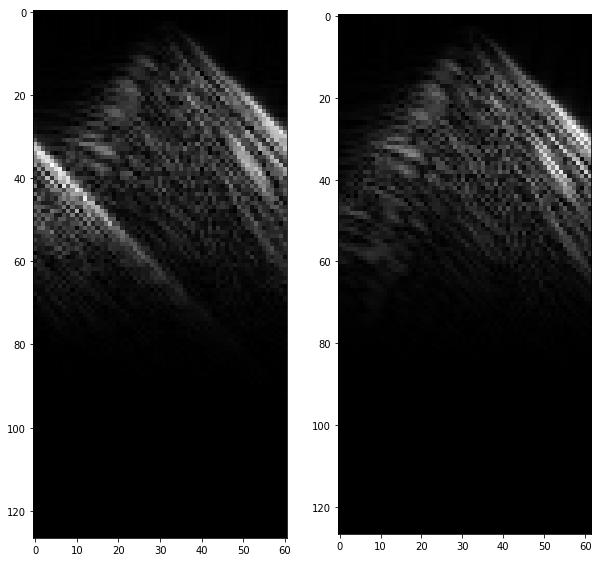

In [53]:
batch_size = 2
is_fk = True
if is_fk:
    filename_x='data_fk_25'
    filename_y='data_fk_125'
else: 
    filename_x='data_25'
    filename_y='data_125'
#load the data
data = Data(filename_x=filename_x, filename_y=filename_y)
#split the data
train_data, test_data = random_split(data, [40,21])
#put the train set into dataloader
train_dataloader = DataLoader(train_data, batch_size = batch_size, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size = 1, drop_last=True)
for batch in train_dataloader:
    print(batch['x'][0].squeeze(0).shape)
    print(batch['y'][0].squeeze(0).shape)
    plt.subplot(1, 2, 1)
    plt.imshow(batch['x'][0].squeeze(0),cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(batch['y'][0].squeeze(0),cmap='gray')
    plt.show()
    break

In [54]:

#overview of different models
# model described here http://personal.ie.cuhk.edu.hk/~ccloy/files/eccv_2014_deepresolution.pdf

class SRCNN(nn.Module):
    """Basic benchmark model, paper introducing the model is http://personal.ie.cuhk.edu.hk/~ccloy/files/eccv_2014_deepresolution.pdf"""
    def __init__(self, latent_dim= [64,32], input_dim = (251,61) , output_dim = [251,121] ):
        super(SRCNN, self).__init__()
        self.output_dim = output_dim
        self.sequence = nn.Sequential()
        #actually dimensions have to be changed, here's a tutorial http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html
        self.sequence.add_module("Convolution 1", nn.Conv2d(1, latent_dim[0], kernel_size = 9, padding = 4))
        self.sequence.add_module("ReLU 1", nn.ReLU())
        self.sequence.add_module("Convolution 2", nn.Conv2d(latent_dim[0], latent_dim[1], kernel_size = 1 , padding = 0))
        self.sequence.add_module("ReLU 2", nn.ReLU())
        self.sequence.add_module("Convolution 3", nn.Conv2d(latent_dim[1], 1, kernel_size = 5 , padding = 2))
    
    def forward(self, x):
        x_interpolated = nn.functional.interpolate(x, size=self.output_dim)
        
        return self.sequence(x_interpolated)




Epoch 0, loss 202.16335220336913
Epoch 1, loss 134.70147972106935
Epoch 2, loss 120.36673507690429
Epoch 3, loss 113.78447532653809
Epoch 4, loss 109.66778144836425
Epoch 5, loss 104.64949569702148
Epoch 6, loss 99.62517204284669
Epoch 7, loss 92.717240524292
Epoch 8, loss 86.79591064453125
Epoch 9, loss 82.98975563049316
Epoch 10, loss 79.76314334869384
Epoch 11, loss 75.73307800292969
Epoch 12, loss 72.74838676452637
Epoch 13, loss 70.28682594299316
Epoch 14, loss 68.81825466156006
Epoch 15, loss 66.700364112854
Epoch 16, loss 65.4699592590332
Epoch 17, loss 64.72895641326905
Epoch 18, loss 62.90286865234375
Epoch 19, loss 62.50687236785889
Epoch 20, loss 60.5207498550415
Epoch 21, loss 61.35443172454834
Epoch 22, loss 58.37030143737793
Epoch 23, loss 60.551741981506346
Epoch 24, loss 57.079311561584475
LR decreases. New lr is 0.01
Epoch 25, loss 57.24391593933105
Epoch 26, loss 56.97375011444092
Epoch 27, loss 53.84474391937256
Epoch 28, loss 54.746425247192384
Epoch 29, loss 51.600

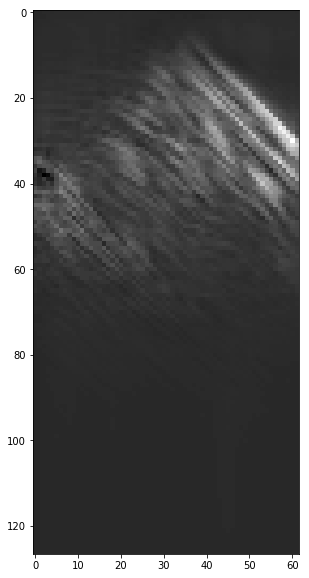

In [65]:
torch.manual_seed(42)
if is_fk:
    output_dim = [127,62]
else:
    output_dim = [251,121]
model = SRCNN(output_dim = output_dim)
optimiser = torch.optim.Adam(params=model.parameters(), lr = 1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimiser, step_size=1)
loss_function = nn.MSELoss()
def training(model, optimiser, train_dataloader, loss_function = nn.MSELoss(),  epoch_number = 40, device = 'cpu'):
    model.to(device)
    loss_epoch = []
    for epoch in range(epoch_number):
        if epoch == 25:
            pass
            #scheduler.step()
            #print("LR decreases. New lr is {}".format(optimiser.param_groups[0]['lr']))
        loss_list = []
        for batch in train_dataloader:
            
            x = batch["x"].to(device =device).float()
            y = batch["y"].to(device =device).float()
            model.train()
            optimiser.zero_grad()
            y_reconstructed = model(x)
            loss = loss_function(y_reconstructed, y)
            loss.backward()
            optimiser.step()
            
            loss_list+=[loss.item()]
        print("Epoch {}, loss {:4}".format(epoch, np.mean(loss_list)))
        loss_epoch+=[np.mean(loss_list)]
    
        
    
    plt.imshow(y_reconstructed[0].squeeze(0).detach().numpy(),cmap='gray')
    plt.show()
    
training(model, optimiser, train_dataloader, loss_function = loss_function)

47.108436584472656


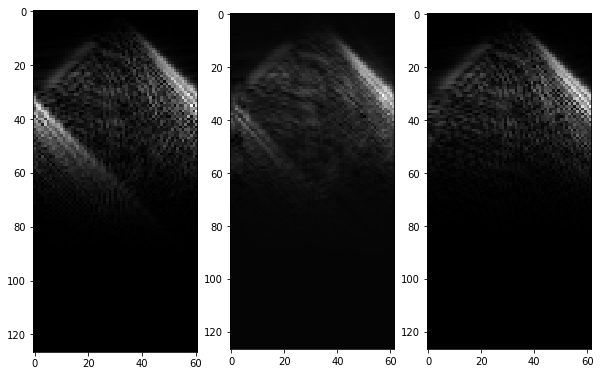

35.322174072265625


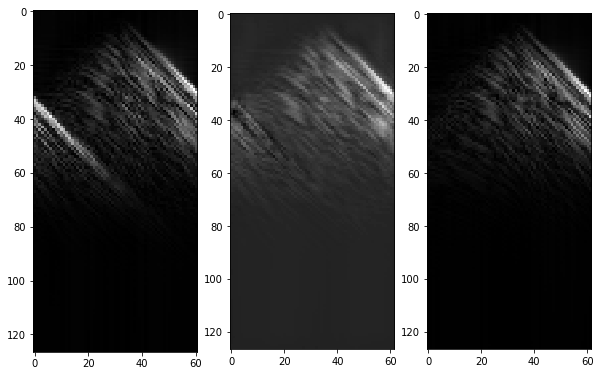

44.289791107177734


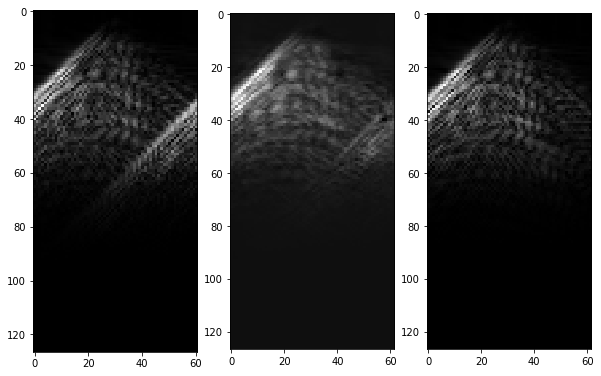

36.08018493652344


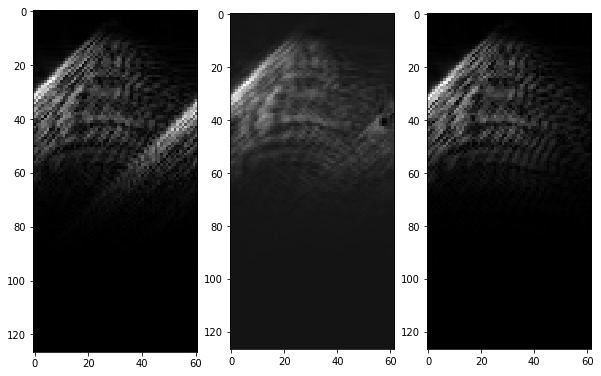

54.394744873046875


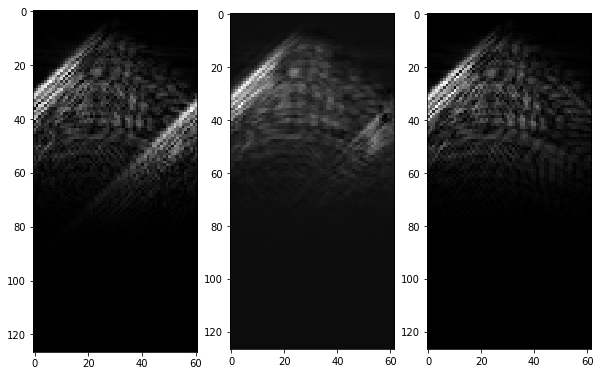

29.00250244140625


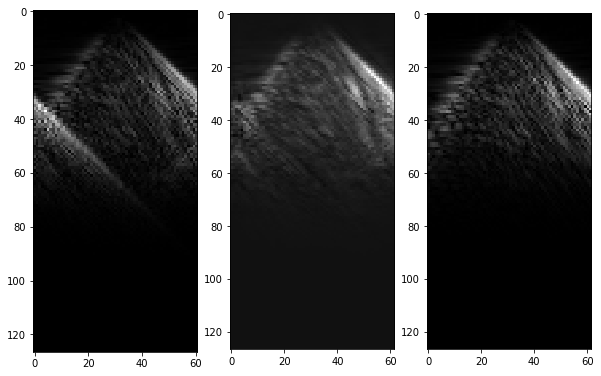

37.585899353027344


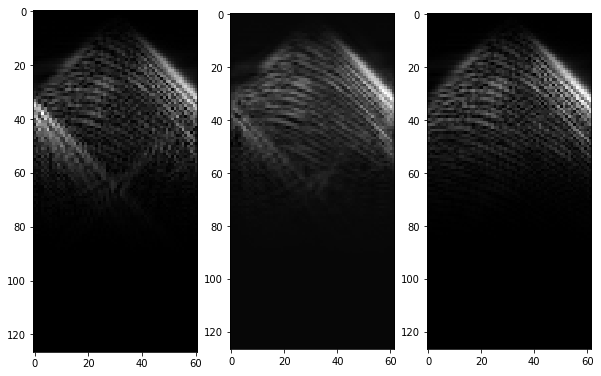

45.43722152709961


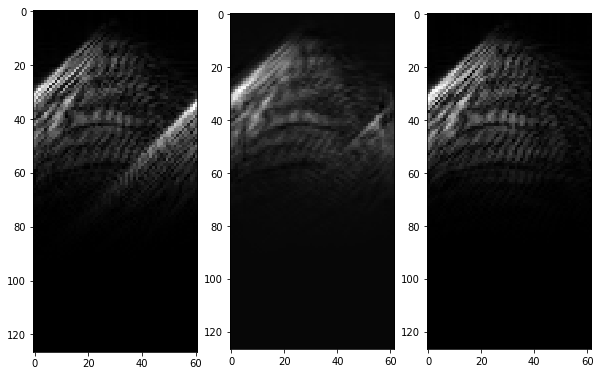

41.08706283569336


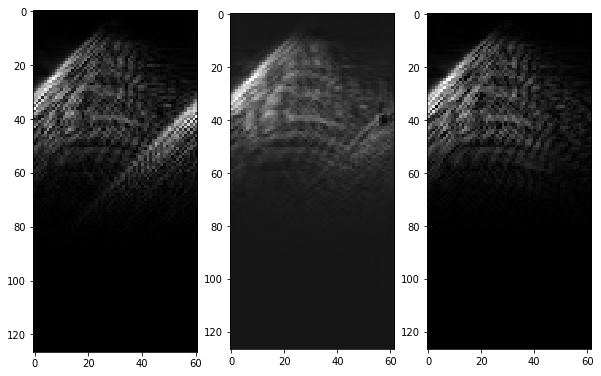

46.366703033447266


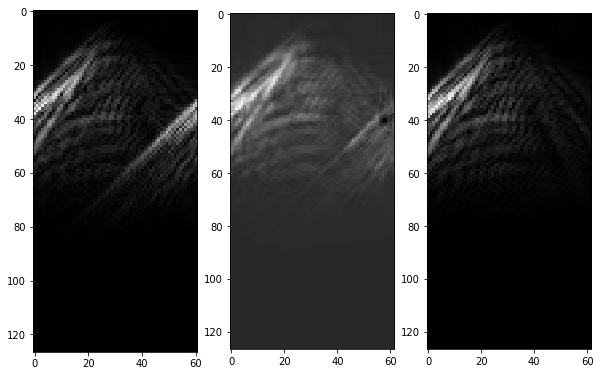

38.63867950439453


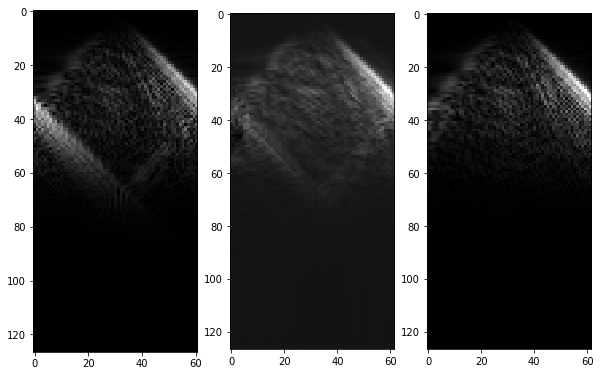

34.52787780761719


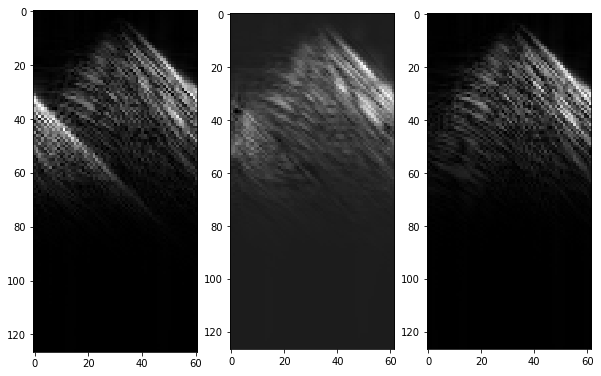

42.36747360229492


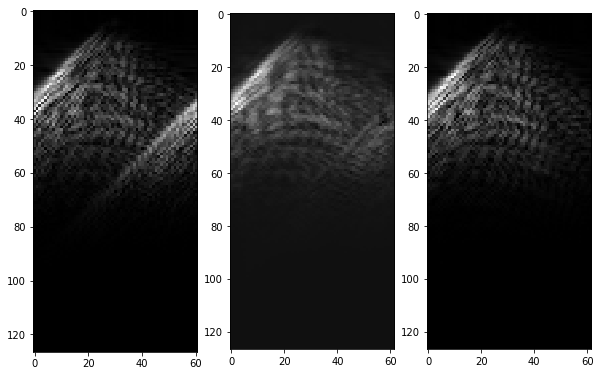

45.01709747314453


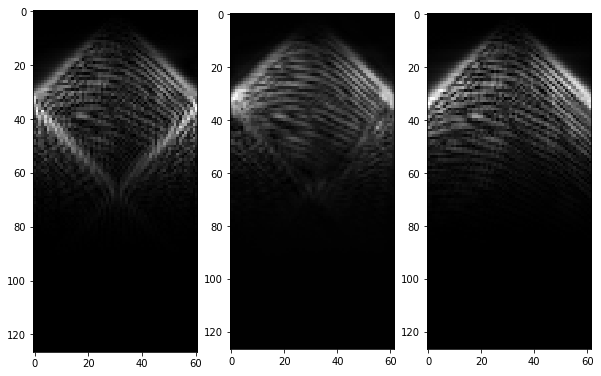

45.40108108520508


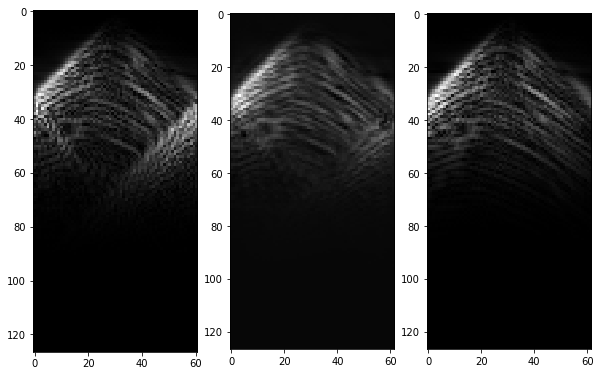

47.842041015625


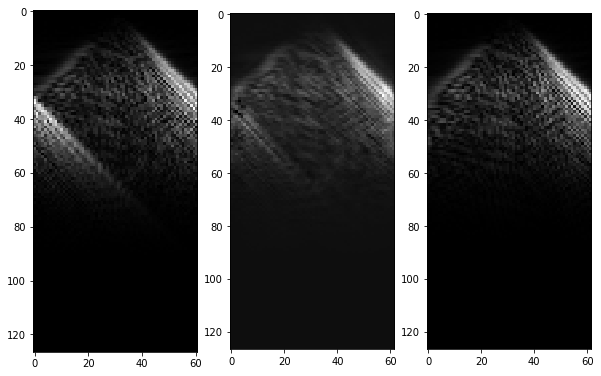

39.63778305053711


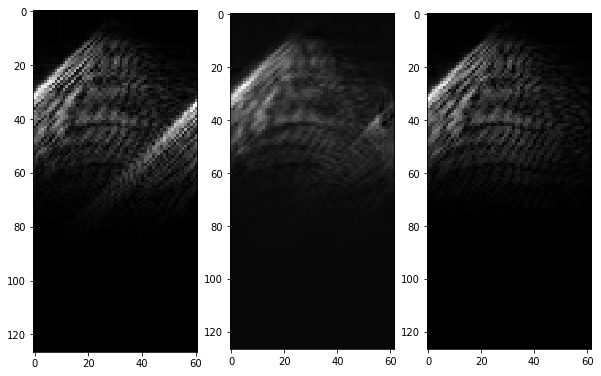

36.55882263183594


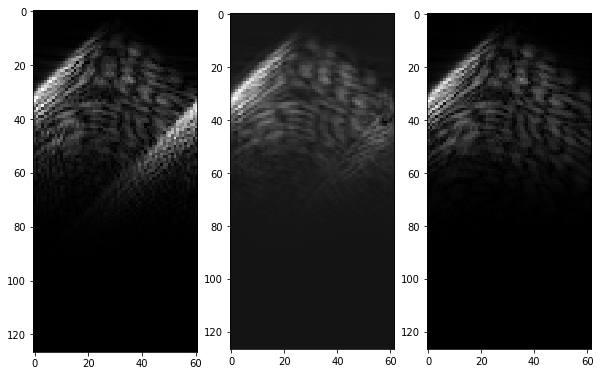

36.6639518737793


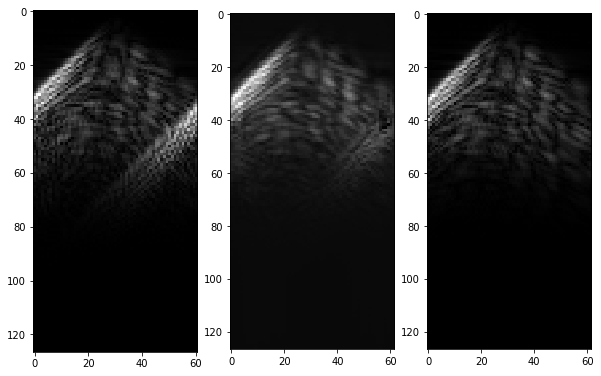

55.41639709472656


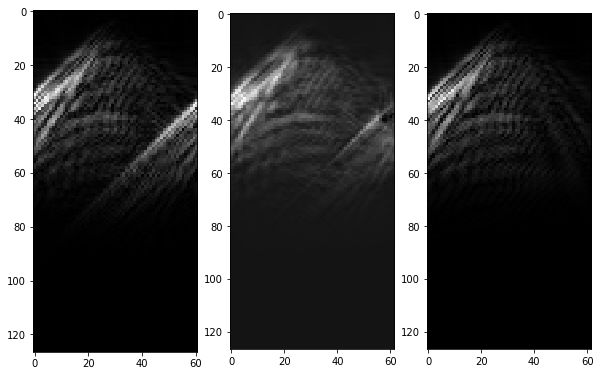

58.275943756103516


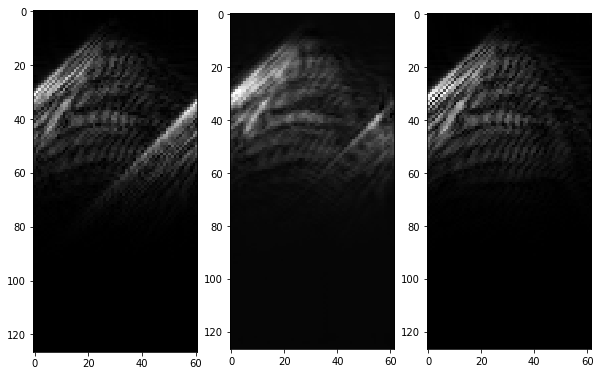

In [66]:
model.eval()
device = 'cpu'
for batch in test_dataloader:
    x = batch["x"].to(device=device).float()
    y = batch["y"].to(device=device).float()
    y_reconstructed = model(x)
    loss = loss_function(y_reconstructed, y)
    print(loss.item())
    plt.subplot(1, 3, 1)
    plt.imshow(x[0].squeeze(0),cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(y_reconstructed[0].squeeze(0).detach().numpy(),cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(y[0].squeeze(0),cmap='gray')
    plt.show()
    